# Outbreak size in the SIR model (Kermack-McKendrick relation)

We move next to the Susceptible-Infected-Recovered model, the first of these canonical test models that actually provides a decent, coarse, representation of many vaccine-preventable diseases that we are interested in.  This test will explore the size of acute outbreaks; in this situation, the role of demography is pretty small and serves only to complicate the analysis, so we will work without demography.  The model contains three agent states and two transitions: susceptible -> infected -> recovered, with the recovered state assumed to be lifelong.

$$
\dot{S} = -\frac{\beta*S*I}{N} \\

\dot{I} = \frac{\beta*S*I}{N} - \gamma I \\

\dot{R} = \gamma I
$$

Analysis of this system can be found in other sources, and closed-form analytic solutions to the system dyanmics are elusive and generally too complicated to provide much insight - more generally useful are results about the equilibrium states as  $t \rightarrow \infty$.  We'll focus here on one of these, the size of an outbreak introduced into a closed population, given by the implicit formula

$$ 
Z = 
\begin{cases}
    S_0(1-e^{-R_0[Z+I_0]}), & \text{if} \:\:  R_0S(0)>1 \\
    0, &\text{if} \:\:  R_0S(0)<=1
\end{cases} \\
Z = \sum_{t=0}^\infty I(t) = S_0 - S_\infty \\
R_0 = \frac{\beta}{\gamma}
$$

One can obtain an approximate analytic solution for the outbreak curve itself, shown below. I may return to this notebook and explore the possibility of testing the model against this later.  However, the approximation employed in deriving this is that $R_0 R(t)$ is small, which is likely to be violated over the course of the outbreak.  And it's immediately clear upon looking at this formula that it doesn't exactly offer some intuitive interpretation for the dynamics.

$$
\frac{dR}{dt} = \frac{\gamma \alpha^2}{2S(0)R_0^2}\text{sech}^2\left(\frac{\alpha \gamma t}{2} - \phi\right) \\
\phi = \text{tanh}^{-1}\left(\frac{S(0)(R_0-1)}{\alpha}\right) \\
\alpha = \sqrt{S(0)^2(R_0-1)^2 + 2S(0)I(0)R_0^2}
$$


This notebook tests the implementation and behavior of the model as follows:
### Contruct the model
In the first few cells, we do all the necessary imports.  Then we construct a single-patch LASER model with three components: `Susceptibility`, `Transmission`, and `Infection`.  The `Susceptibility` component adds an agent property `susceptibility`, and the `Infection` component will require a new agent property `itimer`.  The `S` state is defined by `susceptibility==1`, the `I` state by `itimer>0`, and the `R` state by `itimer<=0 and susceptibility==0`.  Finally, we initialize with a handful of infections and run.  The `Susceptibility` and `Transmission` components are previously described. 

### Sanity check
The first test, as always, ensures that certain basic constraints are being obeyed by the model.  As it stands, I am not actually explicitly tracking the recovered population, but I can check that $S_t = N_t - \sum{\Delta_I}$.  

### Scientific test
The scientific test will loop over a set of $(R_0, S(0))$ pairs and confirm that the final outbreak size matches the expectation given in the equaiton above.  As this is a stochastic model, the main concern is that when $R_0S(0)$ is close to one, the outbreak may fail to take off or truncate at a slightly smaller final size.  



In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
from scipy.optimize import fsolve
from tqdm.notebook import tqdm #, trange

from laser_generic import Model
from laser_generic.infection import Infection
from laser_generic.susceptibility import Susceptibility
from laser_generic.transmission import Transmission
from laser_generic.utils import seed_infections_randomly
from laser_generic.utils import set_initial_susceptibility_randomly

f"{np.__version__=}"

"np.__version__='1.26.4'"

2025-02-03 19:16:18.546361: Creating the generic model…
Initializing the generic model with 1 patches…
2025-02-03 19:16:18.555068: Running the generic model for 730 ticks…


  0%|          | 0/730 [00:00<?, ?it/s]

Completed the generic model at 2025-02-03 19:16:22.139823…
Susceptibility_census:       166,754 µs
Transmission_census  :       265,480 µs
Infection_census     :       504,630 µs
Model                :         5,324 µs
Susceptibility       :         1,232 µs
Transmission         :     5,012,324 µs
Infection            :     1,091,346 µs
Total:                     7,047,090 microseconds


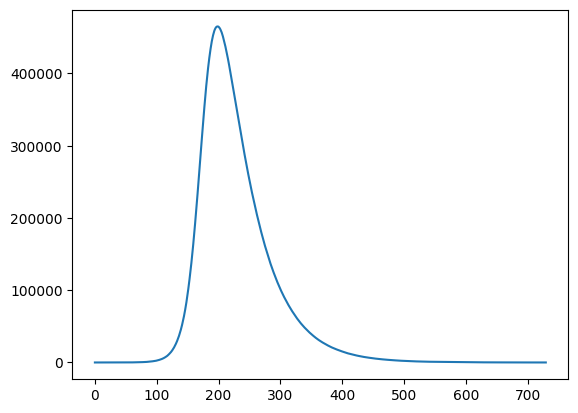

In [8]:
pop = 1e6
nticks = 730
scenario = pd.DataFrame(data=[["homenode", pop]], columns=["name", "population"])
parameters = PropertySet({"seed": 2, "nticks": nticks, "verbose": True, "beta": 0.1, "inf_mean": 50})
model = Model(scenario, parameters)
model.components = [
    Susceptibility,
    Transmission,
    Infection,
]

set_initial_susceptibility_randomly(model, 1.0)
seed_infections_randomly(model, ninfections=1)
model.run()
plt.plot(model.patches.cases)
plt.show()

# Sanity checks
Check that the relationships between susceptible, infected, and total population hold.

In [3]:
cases = np.squeeze(model.patches.cases)
susc = np.squeeze(model.patches.susceptibility)
rec = np.squeeze(model.patches.recovered)
inc = np.squeeze(model.patches.incidence)
pops = np.squeeze(model.patches.populations)[:-1]

print('S+I+R = N:  '+str(np.isclose(cases+susc+rec, pops).all()))
print('S = N - sum(deltaI): '+str(np.isclose(pops[1:]-susc[1:], 1+np.cumsum(inc)[:-1]).all()))  #Account for 1 timestep offset here



S+I+R = N:  True
S = N - sum(deltaI): True


## Scientific test
We will now loop over a few values of R-zero and initial susceptibility, and compare the size of the outbreak against the expected size given by the equation in the introduction

In [4]:
def KM_limit(z, R0, S0, I0):
    if R0 * S0 < 1:
        return 0
    else:
        return z - S0 * (1 - np.exp(-R0 * (z + I0)))


In [5]:
%%capture
population = 1e5
inf_mean = 20
init_inf = 20

R0s = np.concatenate((np.linspace(0.2, 1.0, 5), np.linspace(1.5, 10.0, 25)))
S0s = [1.0, 0.8, 0.6, 0.4, 0.2]
output = pd.DataFrame(list(itertools.product(R0s, S0s)), columns=["R0", "S0"])
output["I_inf_exp"] = [
    fsolve(KM_limit, 0.5 * (R0 * S0 >= 1), args=(R0, S0 , init_inf / population))[0] for R0, S0 in zip(output["R0"], output["S0"])
]
output["S_inf_exp"] = output["S0"] - output["I_inf_exp"]
output["I_inf_obs"] = np.nan
output["S_inf_obs"] = np.nan


for index, row in tqdm(output.iterrows()):
    scenario = pd.DataFrame(data=[["homenode", population]], columns=["name", "population"])
    parameters = PropertySet({"seed": 2, "nticks": 1460, "verbose": True, "inf_mean": inf_mean, "beta": row["R0"] / inf_mean})

    model = Model(scenario, parameters)
    model.components = [
        Susceptibility,
        Transmission,
        Infection,
    ]
    set_initial_susceptibility_randomly(model, row["S0"])
    seed_infections_randomly(model, ninfections=init_inf)
    model.run()

    output.loc[index, "I_inf_obs"] = (np.sum(model.patches.incidence) +init_inf)/ population  #incidence doesn't count the imported infections
    output.loc[index, "S_inf_obs"] = model.patches.susceptibility[-1] / population


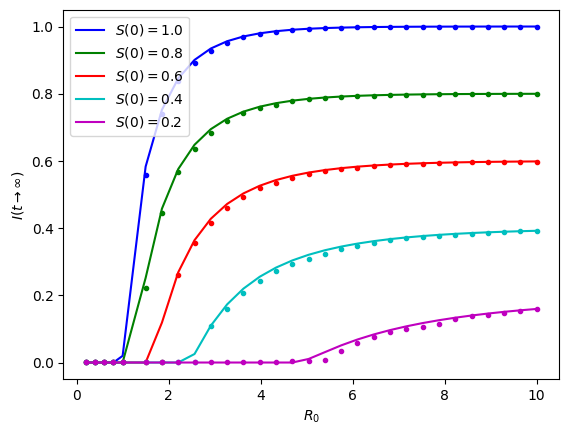

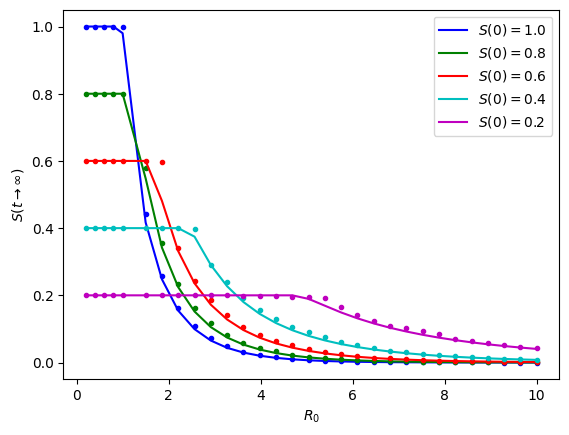

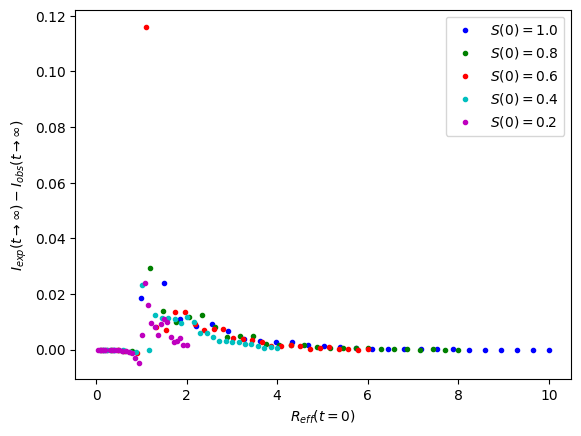

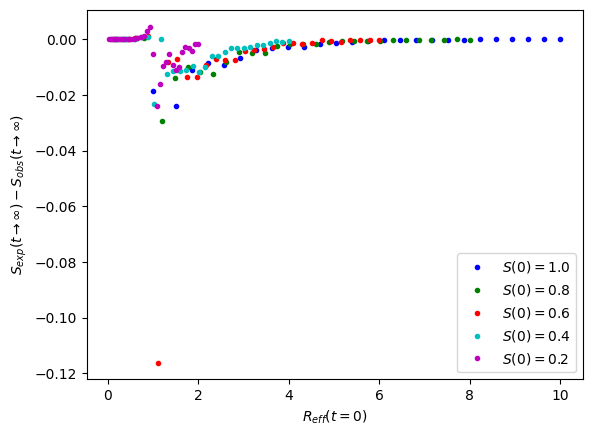

In [6]:
plt.figure()
colors = itertools.cycle(["b", "g", "r", "c", "m", "y", "k"])
for S0 in S0s:
    condition = output["S0"] == S0
    color = next(colors)
    plt.plot(output[condition]["R0"], output[condition]["I_inf_exp"], color=color)
    plt.plot(output[condition]["R0"], output[condition]["I_inf_obs"], ".", label='_nolegend_', color=color)
plt.xlabel("$R_{0}$") 
plt.ylabel(r"$I(t \rightarrow {\infty})$")
plt.legend(["$S(0) = 1.0$", "$S(0)= 0.8$", "$S(0) = 0.6$", "$S(0) = 0.4$", "$S(0) = 0.2$"])
plt.figure()

colors = itertools.cycle(["b", "g", "r", "c", "m", "y", "k"])
for S0 in S0s:
    condition = output["S0"] == S0
    color = next(colors)

    plt.plot(output[condition]["R0"], output[condition]["S_inf_exp"], color=color)
    plt.plot(output[condition]["R0"], output[condition]["S_inf_obs"], ".", label="_nolegend_", color=color)
plt.xlabel("$R_{0}$") 
plt.ylabel(r"$S(t \rightarrow {\infty})$")
plt.legend(["$S(0) = 1.0$", "$S(0)= 0.8$", "$S(0) = 0.6$", "$S(0) = 0.4$", "$S(0) = 0.2$"])

plt.figure()
colors = itertools.cycle(["b", "g", "r", "c", "m", "y", "k"])
for S0 in S0s:
    condition = output["S0"] == S0
    color = next(colors)

    plt.plot(output[condition]["R0"]*S0, (output[condition]["I_inf_exp"] - output[condition]["I_inf_obs"]), ".", label=f"Observed S0={S0}", color=color)
plt.xlabel("$R_{eff}(t=0)$") 
plt.ylabel(r"$I_{exp}(t \rightarrow {\infty}) - I_{obs}(t \rightarrow {\infty})$")
plt.legend(["$S(0) = 1.0$", "$S(0)= 0.8$", "$S(0) = 0.6$", "$S(0) = 0.4$", "$S(0) = 0.2$"])

plt.figure()
colors = itertools.cycle(["b", "g", "r", "c", "m", "y", "k"])

for S0 in S0s:
    condition = output["S0"] == S0
    color = next(colors)

    plt.plot(output[condition]["R0"]*S0, (output[condition]["S_inf_exp"] - output[condition]["S_inf_obs"]), ".", label=f"Observed S0={S0}", color=color)
plt.xlabel("$R_{eff}(t=0)$") 
plt.ylabel(r"$S_{exp}(t \rightarrow {\infty}) - S_{obs}(t \rightarrow {\infty})$")
plt.legend(["$S(0) = 1.0$", "$S(0)= 0.8$", "$S(0) = 0.6$", "$S(0) = 0.4$", "$S(0) = 0.2$"])


In [7]:
print('S expected - S observed < 0.05: '+str( (np.isclose(output["S_inf_exp"], output["S_inf_obs"], atol=0.05)).all())) #Account for 1 timestep offset here
print('I expected - I observed < 0.05: '+str( (np.isclose(output["I_inf_exp"], output["I_inf_obs"], atol=0.05)).all())) #Account for 1 timestep offset here


S expected - S observed < 0.05: False
I expected - I observed < 0.05: False
